## Publishing rate analyzer [Fake data]

This notebook is a proof of concept for the real data analysis. It uses generated data in place of the real data used in the 2017 study: [The Research Productivity of New PhDs in Economics: The Surprisingly High Non-success of the Successful](https://www.aeaweb.org/articles?id=10.1257/jep.28.3.205).

The proof of concept is a mental baseline for myself before doing the real analysis.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import theano.tensor as tt
import pymc3 as pm
import arviz as az

# import warnings
# warnings.filterwarnings('ignore')

sns.set_palette("husl")

In [7]:
fake_data = pd.read_csv("fake_data/fake_data.csv")
fake_data.head()

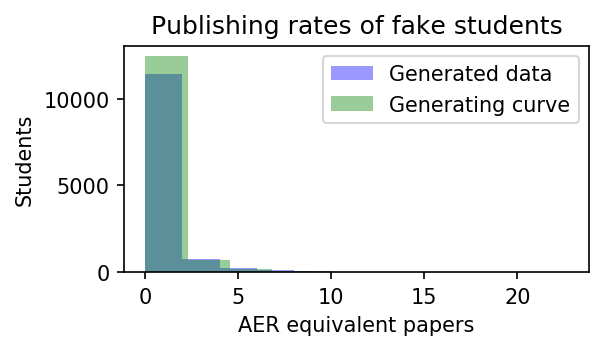

In [58]:
fig, ax = plt.subplots(figsize=(4,2))
fig.set_dpi(150)
ax.hist(fake_data.AERPub, color = "blue", alpha=0.4, label = "Generated data");
ax.hist(np.random.gamma(shape=0.2, scale=3, size=900*15), color="green", alpha=0.4, label="Generating curve");
ax.set(title="Publishing rates of fake students", xlabel="AER equivalent papers", ylabel="Students");
ax.legend();

In [72]:
with pm.Model() as fake_model:
    shape = pm.Uniform("shape", lower=0, upper=2)
    scale = pm.Uniform("scale", lower=0, upper=5)
    gamma = pm.Gamma("liklihood", alpha = shape, beta = scale, observed = fake_data.AERPub)
    
    inf_data = pm.sample(draws = 2000, tune=1000, cores=4, chains=4, step=pm.NUTS(), return_inferencedata=True)
#     trace = pm.sample(draws=2000, tune=1000, cores=4, chains=4)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scale, shape]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8802214524927374, but should be close to 0.8. Try to increase the number of tuning steps.


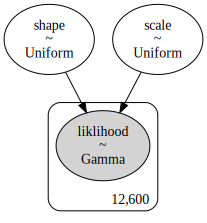

In [60]:
pm.model_to_graphviz(fake_model)

In [61]:
print("Free variables: ", fake_model.free_RVs)
print("Observed variables: ", fake_model.observed_RVs)

Free variables:  [shape_interval__, scale_interval__]
Observed variables:  [liklihood]


In [67]:
inf_data.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    shape    (chain, draw) float64 0.1994 0.1994 0.202 ... 0.2002 0.1978 0.1978
    scale    (chain, draw) float64 0.3338 0.3338 0.3323 ... 0.331 0.3252 0.3252
Attributes:
    created_at:                 2020-09-02T14:18:39.888267
    arviz_version:              0.9.0
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              24.514123916625977
    tuning_steps:               1000

In [63]:
inf_data.posterior.shape

<xarray.DataArray 'shape' (chain: 4, draw: 2000)>
array([[0.19937539, 0.19937539, 0.20204886, ..., 0.1984426 , 0.19889675,
        0.20003188],
       [0.19917889, 0.19797113, 0.19974225, ..., 0.1986224 , 0.19713722,
        0.19924669],
       [0.20180622, 0.20212689, 0.19875302, ..., 0.19947808, 0.20093947,
        0.20088861],
       [0.20221176, 0.20135526, 0.20006828, ..., 0.20015502, 0.1978494 ,
        0.1978494 ]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [69]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
shape,0.20,0.002,0.197,0.204,0.0,0.0,5162.0,5162.0,5145.0,4933.0,1.0
scale,0.33,0.007,0.316,0.344,0.0,0.0,5322.0,5315.0,5325.0,5381.0,1.0


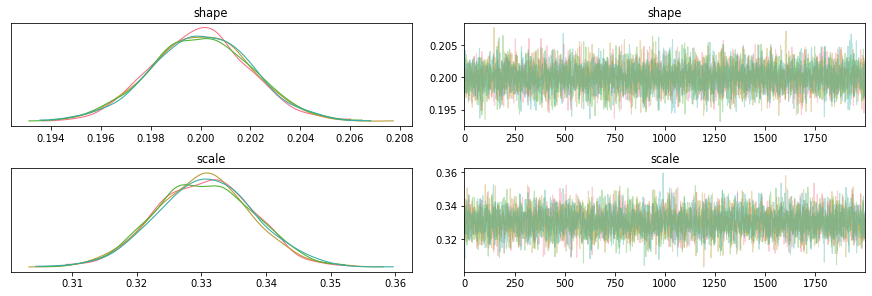

In [34]:
# The shape is correct, but the scale may be off here. Confirm.
az.plot_trace(inf_data);

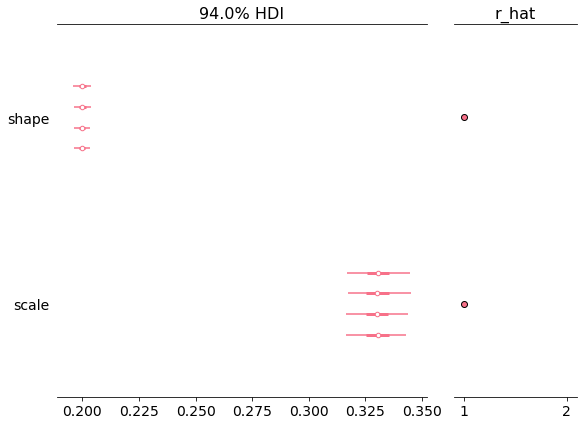

In [36]:
az.plot_forest(inf_data, r_hat=True);

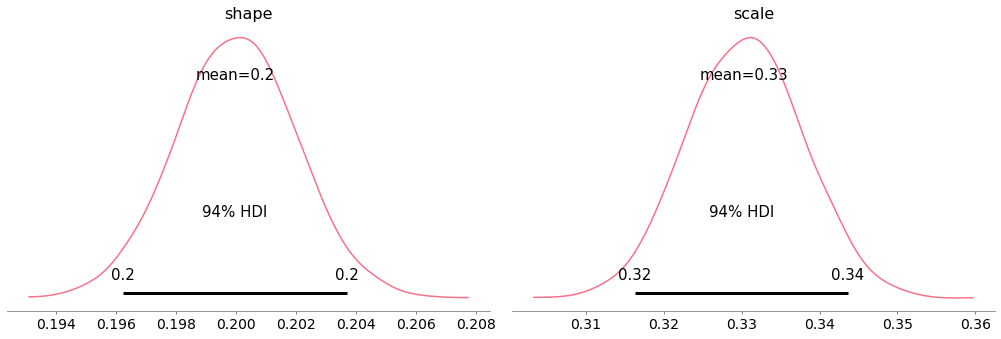

In [38]:
az.plot_posterior(inf_data);

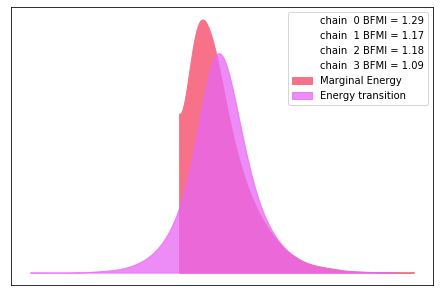

In [41]:
# TODO - look up energy plot interpretation
az.plot_energy(inf_data);

In [78]:
with fake_model:
    posterior_predictions_dict = pm.sample_posterior_predictive(inf_data.posterior)    

In [87]:
combined_inf_data = az.concat(inf_data, az.from_pymc3(posterior_predictive=posterior_predictions_dict), inplace=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

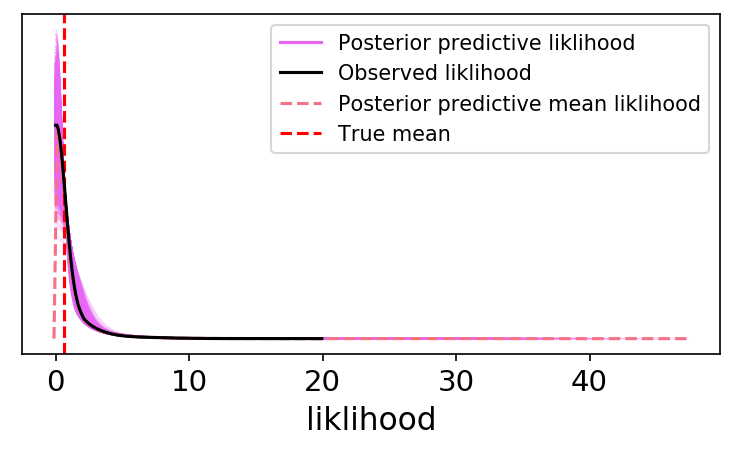

In [91]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_dpi(150)
az.plot_ppc(combined_inf_data, ax=ax)
ax.axvline(fake_data.AERPub.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);